In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import logit
from statsmodels.formula.api import ols
#모델 빌딩용 데이터, 테스트 데이터 쪼개기
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

import pickle
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from bs4 import BeautifulSoup as bs
from nltk.corpus import stopwords
import re
#from tensorflow.python.keras.preprocessing.sequence import pad_sequences
#from tensorflow.python.keras.preprocessing.text import Tokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cupid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cupid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cupid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cupid\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


###  general에서 필요한 컬럼 가져오기!

In [2]:
general = pd.read_csv('general_final.csv')#, header=0, delimiter='\t',quoting=3)
df = general[['story','success','group_category']] # 두 가지 컬럼만 df에 넣기
conditionlist = [
    (general['created_date'] <= '2020-02-28') ,
    (general['created_date'] >= '2020-03-01') & (general['created_date'] <= '2020-06-30'),
    (general['created_date'] >= '2020-07-01') & (general['created_date'] <= '2020-11-04')]
choicelist = ['before_covid', 'during_covid', 'after_covid']
df['period'] = np.select(conditionlist, choicelist, default='Not Specified')

In [3]:
all_words = general[['story']]

In [4]:
# 성공&실패 가져오기
df_su = df[df['success'] == True] # 성공인 것만 골라서 df_su에 넣기
df_fa = df[df['success']==False] # 실패인 것만 골라서 df_fa에 넣기
success = df_su[['story']] # 성공인 것의 story만 success에 넣기
failure = df_fa[['story']] # 실패인 것의 story만 failure에 넣기
# 위는 모두 DataFrame 타입

In [5]:
# 카테고리 가져오기
df_me = df[df['group_category'] == 'Medical, Illness & Healing'] 
df_ac = df[df['group_category']== 'Accidents & Emergencies'] 
df_fu = df[df['group_category'] == 'Funerals & Memorials']
df_ot = df[df['group_category'] == 'Others']
medical = df_me[['story']] 
accidents = df_ac[['story']] 
funeral = df_fu[['story']] 
others = df_ot[['story']] 

# 위는 모두 DataFrame 타입

In [6]:
# 시기별 가져오기
df_bc = df[df['period'] == 'before_covid'] 
df_dc = df[df['period']=='during_covid'] 
df_ac = df[df['period']=='after_covid']
beco = df_bc[['story']]
duco = df_dc[['story']]
afco = df_ac[['story']]
# 위는 모두 DataFrame 타입

### DataFrame 타입을 텍스트파일로 내보내기!

In [224]:
all_words.to_csv('all.txt', index=False, sep="\t")
success.to_csv('success.txt', index=False, sep="\t")
failure.to_csv('failure.txt', index=False, sep='\t')
medical.to_csv('medical.txt', index=False, sep="\t")
accidents.to_csv('accidents.txt', index=False, sep='\t')
funeral.to_csv('funeral.txt', index=False, sep="\t")
others.to_csv('others.txt', index=False, sep='\t')
beco.to_csv('beco.txt', index=False, sep="\t")
duco.to_csv('duco.txt', index=False, sep='\t')
afco.to_csv('afco.txt', index=False, sep='\t')

### 전체 단어 살펴보기!!

In [8]:
## 혹시나, 다른언어가 들어 있는 것일 경우에는 tokenize -> lemmatize -> pos_tag -> [^a-zA-Z] -> stopwords -> Counter 
## (stemming 뒤에는 명사 구분이 힘들기 때문에 lemmatize가 바로 뒤에 들어가고 그 후 pos_tag필요)

In [9]:
# 1. 텍스트 데이터 불러오기
with open('all.txt', 'r', encoding='utf8') as all_words:
    all_words = all_words.read()

In [10]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
all_en = re.sub('[^a-zA-z]', ' ',all_words).lower()

In [11]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
all_token = nltk.word_tokenize(all_en)

In [12]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in all_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [13]:
# lemmatizer말고 snowball 스테머도 사용가능
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#lemmatized_word = []
#for word in su_token:
#    new_word = stemmer.stem(word)
#    lemmatized_word.append(new_word)

In [14]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [15]:
# 6. 불용어제거
all_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(all_final))
#su_en_1[:10]

378908


In [16]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
all_final_1 = [w for w in all_final if not w in customized_stopwords]
print(len(all_final_1))


372699


In [19]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(all_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
all_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
all_fr.columns=['all_words','all_counts']
all_fr

,all_words,all_counts
0,family,8060
1,time,4133
2,life,3946
3,year,3388
4,community,3119
5,support,2984
6,fund,2936
7,friend,2797
8,donation,2440
9,help,2104


### 1. 성공/실패
#### 1) 성공

In [20]:
## 혹시나, 다른언어가 들어 있는 것일 경우에는 tokenize -> lemmatize -> pos_tag -> [^a-zA-Z] -> stopwords -> Counter 
## (stemming 뒤에는 명사 구분이 힘들기 때문에 lemmatize가 바로 뒤에 들어가고 그 후 pos_tag필요)

In [21]:
# 1. 텍스트 데이터 불러오기
with open('success.txt', 'r', encoding='utf8') as s:
    success = s.read()

In [22]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
su_en = re.sub('[^a-zA-z]', ' ',success).lower()

In [23]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
su_token = nltk.word_tokenize(su_en)

In [24]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in su_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [25]:
# lemmatizer말고 snowball 스테머도 사용가능
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#lemmatized_word = []
#for word in su_token:
#    new_word = stemmer.stem(word)
#    lemmatized_word.append(new_word)

In [26]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [27]:
# 6. 불용어제거
s_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(s_final))
#su_en_1[:10]

138762


In [28]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
s_final_1 = [w for w in s_final if not w in customized_stopwords]
print(len(s_final_1))


136399


In [29]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(s_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
su_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
su_fr.columns=['success_words','success_counts']
su_fr

,success_words,success_counts
0,family,3298
1,time,1716
2,life,1508
3,year,1256
4,friend,1191
5,fund,1107
6,support,1096
7,community,1004
8,donation,888
9,home,843


#### 2) 실패

In [30]:
# 1. 텍스트 데이터 불러오기
with open('failure.txt', 'r', encoding='utf8') as f:
    failure = f.read()

In [31]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
fa_en = re.sub('[^a-zA-z]', ' ',failure).lower()

In [32]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
fa_token = nltk.word_tokenize(fa_en)

In [33]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in fa_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [34]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [35]:
# 6. 불용어제거
f_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(f_final))
#su_en_1[:10]

240136


In [36]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
f_final_1 = [w for w in f_final if not w in customized_stopwords]
print(len(f_final_1))

236292


In [37]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(f_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
fa_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
fa_fr.columns=['failure_words','failure_counts']
fa_fr

,failure_words,failure_counts
0,family,4762
1,life,2438
2,time,2417
3,year,2132
4,community,2115
5,support,1890
6,fund,1829
7,friend,1605
8,donation,1552
9,help,1399


In [38]:
## 두 테이블 합치기
su_fa = pd.concat([su_fr,fa_fr], axis=1)
su_fa

,success_words,success_counts,failure_words,failure_counts
0,family,3298,family,4762
1,time,1716,life,2438
2,life,1508,time,2417
3,year,1256,year,2132
4,friend,1191,community,2115
5,fund,1107,support,1890
6,support,1096,fund,1829
7,community,1004,friend,1605
8,donation,888,donation,1552
9,home,843,help,1399


### 2. 시기별
#### 1) before corona

In [39]:
# 1. 텍스트 데이터 불러오기
with open('beco.txt', 'r', encoding='utf8') as bc:
    beco = bc.read()

In [40]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
bc_en = re.sub('[^a-zA-z]', ' ',beco).lower()

In [41]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
bc_token = nltk.word_tokenize(bc_en)

In [42]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in bc_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [43]:
# lemmatizer말고 snowball 스테머도 사용가능
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#lemmatized_word = []
#for word in su_token:
#    new_word = stemmer.stem(word)
#    lemmatized_word.append(new_word)

In [44]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [45]:
# 6. 불용어제거
bc_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(bc_final))
#su_en_1[:10]

67966


In [46]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
bc_final_1 = [w for w in bc_final if not w in customized_stopwords]
print(len(bc_final_1))


66701


In [47]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(bc_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
bc_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
bc_fr.columns=['before_cvd_words','before_cvd_counts']
bc_fr

,before_cvd_words,before_cvd_counts
0,family,1550
1,life,809
2,year,745
3,time,744
4,support,592
5,friend,569
6,community,515
7,fund,499
8,donation,483
9,treatment,460


#### 2) during corona

In [48]:
# 1. 텍스트 데이터 불러오기
with open('duco.txt', 'r', encoding='utf8') as dc:
    duco = dc.read()

In [49]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
dc_en = re.sub('[^a-zA-z]', ' ',duco).lower()

In [50]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
dc_token = nltk.word_tokenize(dc_en)

In [51]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in dc_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [52]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [53]:
# 6. 불용어제거
dc_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(dc_final))
#su_en_1[:10]

171927


In [54]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
dc_final_1 = [w for w in dc_final if not w in customized_stopwords]
print(len(dc_final_1))

169535


In [55]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(dc_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
dc_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
dc_fr.columns=['during_cvd_words','during_cvd_counts']
dc_fr

,during_cvd_words,during_cvd_counts
0,family,3219
1,time,1835
2,community,1804
3,life,1496
4,fund,1453
5,support,1312
6,year,1229
7,donation,1223
8,people,1081
9,friend,1015


#### 3) after corona

In [56]:
# 1. 텍스트 데이터 불러오기
with open('afco.txt', 'r', encoding='utf8') as ac:
    afco = ac.read()

In [57]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
ac_en = re.sub('[^a-zA-z]', ' ',afco).lower()

In [58]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
ac_token = nltk.word_tokenize(ac_en)

In [59]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in ac_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [60]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [61]:
# 6. 불용어제거
ac_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(ac_final))
#su_en_1[:10]

138913


In [62]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
ac_final_1 = [w for w in ac_final if not w in customized_stopwords]
print(len(ac_final_1))

136364


In [63]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(ac_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
ac_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
ac_fr.columns=['after_cvd_words','after_cvd_counts']
ac_fr

,after_cvd_words,after_cvd_counts
0,family,3290
1,life,1640
2,time,1554
3,year,1413
4,friend,1216
5,support,1078
6,fund,981
7,home,901
8,child,805
9,treatment,802


In [64]:
## 시기별 비교 테이블
bc_dc_ac = pd.concat([bc_fr, dc_fr, ac_fr], axis=1)
bc_dc_ac

,before_cvd_words,before_cvd_counts,during_cvd_words,during_cvd_counts,after_cvd_words,after_cvd_counts
0,family,1550,family,3219,family,3290
1,life,809,time,1835,life,1640
2,year,745,community,1804,time,1554
3,time,744,life,1496,year,1413
4,support,592,fund,1453,friend,1216
5,friend,569,support,1312,support,1078
6,community,515,year,1229,fund,981
7,fund,499,donation,1223,home,901
8,donation,483,people,1081,child,805
9,treatment,460,friend,1015,treatment,802


### 3. 카테고리별
#### 1) medical

In [65]:
# 1. 텍스트 데이터 불러오기
with open('medical.txt', 'r', encoding='utf8') as me:
    medical = me.read()

In [66]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
me_en = re.sub('[^a-zA-z]', ' ',medical).lower()

In [67]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
me_token = nltk.word_tokenize(me_en)

In [68]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in me_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [69]:
# lemmatizer말고 snowball 스테머도 사용가능
#from nltk.stem.snowball import SnowballStemmer
#stemmer = SnowballStemmer('english')
#lemmatized_word = []
#for word in su_token:
#    new_word = stemmer.stem(word)
#    lemmatized_word.append(new_word)

In [70]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [71]:
# 6. 불용어제거
me_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(me_final))
#su_en_1[:10]

152918


In [72]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
me_final_1 = [w for w in me_final if not w in customized_stopwords]
print(len(me_final_1))

150256


In [73]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(me_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
me_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
me_fr.columns=['medical_words','medical_counts']
me_fr

,medical_words,medical_counts
0,family,2374
1,treatment,1602
2,life,1569
3,time,1530
4,year,1351
5,cancer,1339
6,hospital,1214
7,day,942
8,support,935
9,friend,869


#### 2) Accidents

In [74]:
# 1. 텍스트 데이터 불러오기
with open('accidents.txt', 'r', encoding='utf8') as a:
    accidents = a.read()

In [75]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
a_en = re.sub('[^a-zA-z]', ' ',accidents).lower()

In [76]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
a_token = nltk.word_tokenize(a_en)

In [77]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in a_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [78]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [79]:
# 6. 불용어제거
a_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(a_final))
#su_en_1[:10]

95254


In [80]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
a_final_1 = [w for w in a_final if not w in customized_stopwords]
print(len(a_final_1))

93660


In [81]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(a_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
a_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
a_fr.columns=['accidents_words','accidents_counts']
a_fr

,accidents_words,accidents_counts
0,family,2195
1,time,1030
2,community,924
3,fund,920
4,home,882
5,support,864
6,life,750
7,year,695
8,donation,691
9,friend,626


#### 3) Funeral

In [82]:
# 1. 텍스트 데이터 불러오기
with open('funeral.txt', 'r', encoding='utf8') as fu:
    funeral = fu.read()

In [83]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
fu_en = re.sub('[^a-zA-z]', ' ',funeral).lower()

In [84]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
fu_token = nltk.word_tokenize(fu_en)

In [85]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in fu_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [86]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [87]:
# 6. 불용어제거
fu_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(fu_final))
#su_en_1[:10]

64258


In [88]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
customized_stopwords = ['wa'] # 직접 만든 불용어 사전
fu_final_1 = [w for w in fu_final if not w in customized_stopwords]
print(len(ac_final_1))

136364


In [89]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(fu_final_1) # input type should be a list of words (or tokens)
#print(c)
#k = 20
fu_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
fu_fr.columns=['funeral_words','funeral_counts']
fu_fr

,funeral_words,funeral_counts
0,family,2694
1,life,1178
2,friend,1137
3,time,999
4,fund,791
5,year,703
6,child,634
7,wife,629
8,support,556
9,son,493


#### 3) Others

In [90]:
# 1. 텍스트 데이터 불러오기
with open('others.txt', 'r', encoding='utf8') as ot:
    others = ot.read()

In [91]:
# 2. 영문만 남기기 (소문자로) : 영어 형태소 분석기 쓸건데 다른 언어가 들어갈 필요 없다.
ot_en = re.sub('[^a-zA-z]', ' ',others).lower()

In [92]:
# 3. 토큰화하기: 띄어쓰기 기준인가? 나는 nltk 내장 tokenize를 쓸거다.
ot_token = nltk.word_tokenize(ot_en)

In [93]:
# 4. lemmatizer 사용하기 : lemmatize를 하게 되면 단어의 형태가 바뀌므로 품사도 바뀜.
wlem = nltk.WordNetLemmatizer()
lemmatized_words = []
for word in ot_token:
    new_word = wlem.lemmatize(word)
    lemmatized_words.append(new_word)

In [94]:
# 5.pos_tag 하기: 원하는 품사 찾기
tokens_pos = nltk.pos_tag(lemmatized_words)
# 명사 찾기
NN_words = []
for word, pos in tokens_pos:
    if 'NN' in pos:
        NN_words.append(word)
#print(tokens_pos)

In [95]:
# 6. 불용어제거
ot_final = [w for w in NN_words if not w in stopwords.words('english')]
print(len(ot_final))
#su_en_1[:10]

66450


In [96]:
# 위에 불용어 제거 후 이상한 글자 직접 제거해주기
#customized_stopwords = ['wa', 'ha'] # 직접 만든 불용어 사전
#ot_final_1 = [w for w in ot_final if not w in customized_stopwords]
#print(len(ot_final_1))

In [97]:
# 7. 빈도수 세기! 
from collections import Counter
c = Counter(ot_final) # input type should be a list of words (or tokens)
#print(c)
#k = 20
ot_fr = pd.DataFrame(c.most_common(10)) # 빈도수 기준 상위 k개 단어 출력
ot_fr.columns=['other_words','other_counts']
ot_fr

,other_words,other_counts
0,community,1319
1,family,797
2,donation,705
3,year,639
4,food,632
5,support,629
6,people,615
7,time,574
8,fund,558
9,school,518


In [98]:
category_fr = pd.concat([me_fr, a_fr, fu_fr, ot_fr], axis=1)
category_fr

,medical_words,medical_counts,accidents_words,accidents_counts,funeral_words,funeral_counts,other_words,other_counts
0,family,2374,family,2195,family,2694,community,1319
1,treatment,1602,time,1030,life,1178,family,797
2,life,1569,community,924,friend,1137,donation,705
3,time,1530,fund,920,time,999,year,639
4,year,1351,home,882,fund,791,food,632
5,cancer,1339,support,864,year,703,support,629
6,hospital,1214,life,750,child,634,people,615
7,day,942,year,695,wife,629,time,574
8,support,935,donation,691,support,556,fund,558
9,friend,869,friend,626,son,493,school,518


(-0.5, 799.5, 599.5, -0.5)

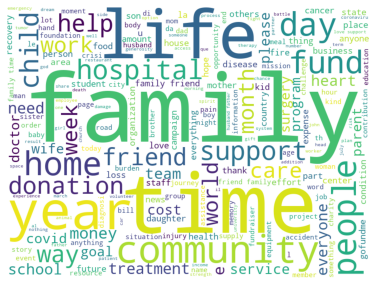

In [99]:
# 전체 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600ㅊ).generate(" ".join(all_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

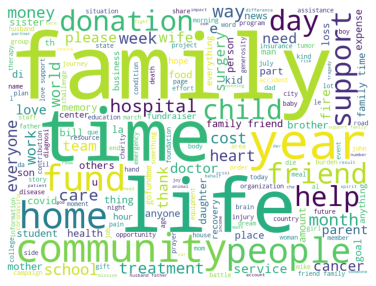

In [109]:
# 성공 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(s_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

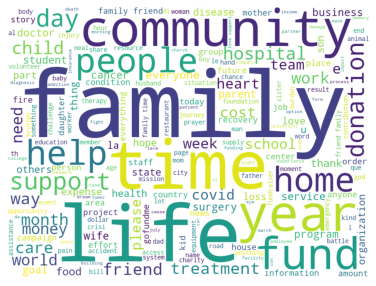

In [101]:
# 실패 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(f_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

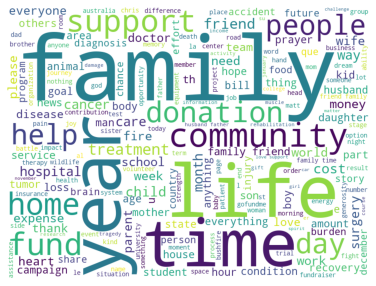

In [102]:
# BC 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(bc_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

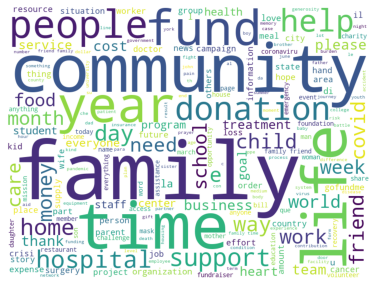

In [103]:
# DC 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(dc_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

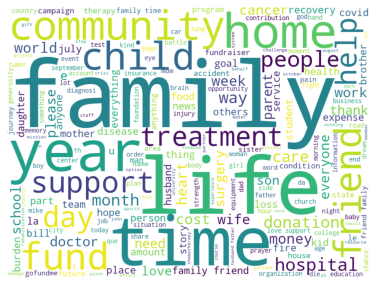

In [104]:
# AC 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(ac_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

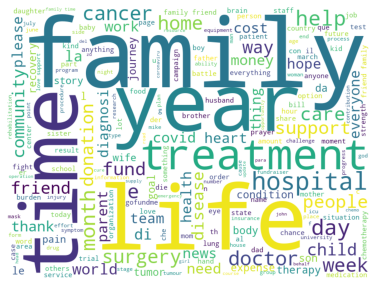

In [105]:
# Medical 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(me_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

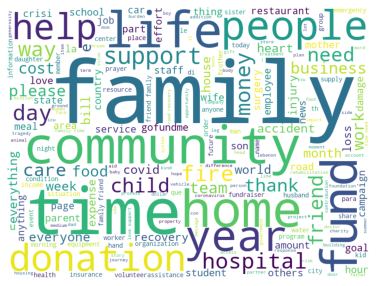

In [106]:
# Accidents 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(a_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

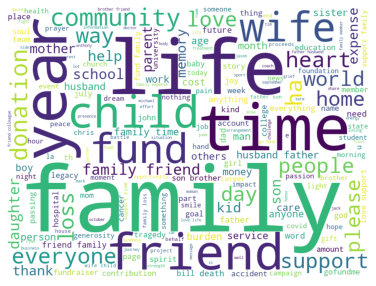

In [107]:
# Funeral 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(fu_final_1))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

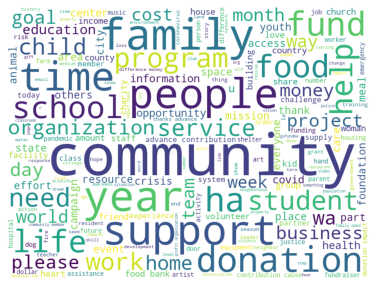

In [108]:
# Others 워드클라우드 만들기
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600, background_color='white').generate(" ".join(ot_final))
plt.figure(figsize=(10,5))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# general에서 story에 사용된 길이 확인
df_su['len'] = df_su['story'].apply(len)
success_length = df_su[df_su['len'] != 48931] # 그래프 비슷해보이려고 뺌

In [ ]:
failure_length = df_fa['story'].apply(len)
failure_length.head()

In [ ]:
# Story 길이별 개수 그래프
plt.figure(figsize=(12,5))
plt.hist(success_length['len'], bins=200, alpha=0.5, color='b', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of story')
plt.xlabel('Length of story')
plt.ylabel('Number of story')

In [ ]:
# Story 길이별 개수 그래프
plt.figure(figsize=(12,5))
plt.hist(failure_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of story')
plt.xlabel('Length of story')
plt.ylabel('Number of story')

In [ ]:
print('리뷰 길이 최대값 : {}'.format(np.max(df_su['len'])))
# 리뷰 길이 최대값 : 13710
print('리뷰 길이 최소값 : {}'.format(np.min(df_su['len'])))
# 리뷰 길이 최소값 : 54
print('리뷰 길이 평균값 : {:.2f}'.format(np.mean(df_su['len'])))
# 리뷰 길이 평균값 : 1329.71
print('리뷰 길이 표준편차 : {:.2f}'.format(np.std(df_su['len'])))
# 리뷰 길이 표준편차 : 1005.22
print('리뷰 길이 중간값 : {}'.format(np.median(df_su['len'])))
# 리뷰 길이 중간값 : 983.0

print('리뷰 길이 제1사분위 : {}'.format(np.percentile(df_su['len'], 25)))
# 리뷰 길이 제1사분위 : 705.0
print('리뷰 길이 제3사분위 : {}'.format(np.percentile(df_su['len'], 75)))
# 리뷰 길이 제3사분위 : 1619.0

In [ ]:
print('리뷰 길이 최대값 : {}'.format(np.max(failure_length)))
# 리뷰 길이 최대값 : 13710
print('리뷰 길이 최소값 : {}'.format(np.min(failure_length)))
# 리뷰 길이 최소값 : 54
print('리뷰 길이 평균값 : {:.2f}'.format(np.mean(failure_length)))
# 리뷰 길이 평균값 : 1329.71
print('리뷰 길이 표준편차 : {:.2f}'.format(np.std(failure_length)))
# 리뷰 길이 표준편차 : 1005.22
print('리뷰 길이 중간값 : {}'.format(np.median(failure_length)))
# 리뷰 길이 중간값 : 983.0

print('리뷰 길이 제1사분위 : {}'.format(np.percentile(failure_length, 25)))
# 리뷰 길이 제1사분위 : 705.0
print('리뷰 길이 제3사분위 : {}'.format(np.percentile(failure_length, 75)))
# 리뷰 길이 제3사분위 : 1619.0

In [ ]:
# 박스 플롯으로도 확인하기
plt.figure(figsize=(10,5))
plt.boxplot(success_length, labels=['counts'], showmeans=True)

In [ ]:
# 각 story에 단어 개수 분포
a = pd.DataFrame(clean_success, columns=['story'])
a['story'] = a['story'].astype(str)
word_counts = a['story'].apply(lambda x:len(x.split(' ')))
ex = a[word_counts != 5557] # 그래프 비슷해보이기 위해 뺌.
success_word_counts = ex['story'].apply(lambda x:len(x.split(' ')))

In [ ]:
# 각 story에 단어 개수 분포
b = pd.DataFrame(clean_failure, columns=['story'])
b['story'] = b['story'].astype(str)
failure_word_counts = b['story'].apply(lambda x:len(x.split(' ')))

In [ ]:
# 그래프
plt.figure(figsize=(10,5))
plt.hist(success_word_counts, bins=50, facecolor='b', label='success')
plt.title('Log-Histogram of word count in story', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of story', fontsize=15)

In [ ]:
# 그래프
plt.figure(figsize=(10,5))
plt.hist(failure_word_counts, bins=50, facecolor='r', label='failure')
plt.title('Log-Histogram of word count in story', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of story', fontsize=15)

In [ ]:
print('단어 개수 최대값 : {}'.format(np.max(success_word_counts)))
# 단어 개수 최대값 : 2470
print('단어 개수 최소값 : {}'.format(np.min(success_word_counts)))
# 단어 개수 최소값 : 10
print('단어 개수 평균값 : {:.2f}'.format(np.mean(success_word_counts)))
# 단어 개수 평균값 : 233.79
print('단어 개수 표준편차 : {:.2f}'.format(np.std(success_word_counts)))
# 단어 개수 표준편차 : 173.74
print('단어 개수 중간값 : {}'.format(np.median(success_word_counts)))
# 단어 개수 중간값 : 174.0

print('단어 개수 제1사분위 : {}'.format(np.percentile(success_word_counts, 25)))
# 단어 개수 제1사분위 : 127.0
print('단어 개수 제3사분위 : {}'.format(np.percentile(success_word_counts, 75)))
# 단어 개수 제3사분위 : 284.0

In [ ]:
print('단어 개수 최대값 : {}'.format(np.max(failure_word_counts)))
# 단어 개수 최대값 : 2470
print('단어 개수 최소값 : {}'.format(np.min(failure_word_counts)))
# 단어 개수 최소값 : 10
print('단어 개수 평균값 : {:.2f}'.format(np.mean(failure_word_counts)))
# 단어 개수 평균값 : 233.79
print('단어 개수 표준편차 : {:.2f}'.format(np.std(failure_word_counts)))
# 단어 개수 표준편차 : 173.74
print('단어 개수 중간값 : {}'.format(np.median(failure_word_counts)))
# 단어 개수 중간값 : 174.0

print('단어 개수 제1사분위 : {}'.format(np.percentile(failure_word_counts, 25)))
# 단어 개수 제1사분위 : 127.0
print('단어 개수 제3사분위 : {}'.format(np.percentile(failure_word_counts, 75)))
# 단어 개수 제3사분위 : 284.0

In [ ]:
qmarks = np.mean(a['story'].apply(lambda x: '?' in x))
fullstop = np.mean(a['story'].apply(lambda x: '.' in x))
capital_first = np.mean(a['story'].apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(a['story'].apply(lambda x: max([y.isdigit() for y in x])))

print('물음표가 있는 문장 : {:.2f}%'.format(qmarks * 100))
# 물음표가 있는 문장 : 29.55%
print('마침표가 있는 문장 : {:.2f}%'.format(fullstop * 100))
# 마침표가 있는 문장 : 99.69%
print('첫 글자가 대문자인 문장 : {:.2f}%'.format(capital_first * 100))
# 첫 글자가 대문자인 문장 : 0.00%
#print('대문자가 있는 문장 : {:.2f}%'.format(capitals * 100))
# 대문자가 있는 문장 : 99.59%
print('숫자가 있는 문장 : {:.2f}%'.format(numbers * 100))
# 숫자가 있는 문장 : 56.66%

In [ ]:
su = np.mean(a['story'].apply(lambda x: 'help' in x))
fa = np.mean(b['story'].apply(lambda x: 'help' in x))


print('성공케이스에서 support가 있는 문장 : {:.2f}%'.format(su * 100))
# 물음표가 있는 문장 : 29.55%
print('실패케이스에서 support가 있는 문장 : {:.2f}%'.format(fa * 100))
# 마침표가 있는 문장 : 99.69%

In [ ]:
family 2877 55.77%
help 2282
support 1629
time 1473
us 1211
life 1113
many 1047
please 921
need 896
would 884

In [ ]:
family 3984 46.77%
help 3981
support 2737
us 2121
time 2018
need 1909
life 1816
community 1728
please 1693
many 1563